In [1]:
using Pkg; Pkg.activate()

using Distributions, Random
using LightGraphs
using Convex, ECOS
using Plots

using Revise
using CarbonNetworks

ECOS_QUIET = () -> ECOS.Optimizer(verbose=false)

┌ Info: Precompiling CarbonNetworks [d5dced0a-5569-40db-8865-1dbf132a76f2]
└ @ Base loading.jl:1317


#1 (generic function with 1 method)

# Make data

### Make network

In [2]:
Random.seed!(2)
n = 50

# Make graph
G = watts_strogatz(n, 4, 0.2)

# Convert to incidence matrix
A = incidence_matrix(G, oriented=true)
m = size(A, 2)

# Generate costs
f = rand(Exponential(5), n) .+ 2

# Generate generation and flow capacities
gmax = rand(Gamma(5.0, 5.0), n)
pmax = rand(Gamma(1.0, 1.0), m);

### Make cases

In [74]:
Random.seed!(3)

num_cases = 500

cases = []
for _ in 1:num_cases
    d = rand(Uniform(0.5, 1.0), n) .* gmax
    
    opf = PowerManagementProblem(f, d, pmax, gmax, A)
    solve!(opf, ECOS_QUIET)
    
    push!(cases, (d=d, g=evaluate(opf.g)))
end

train_cases = cases[1:400]
test_cases = cases[401:end];

# Compute gradient

We want to solve 

$$\text{minimize}_\theta\quad L(g^*(\theta)) + \frac{\lambda}{2} \| f \|_2^2$$
    
where $L(g) = \frac{1}{2} \| g - g_{\mathrm{true}} \|_2^2$ and $g^*(\theta)$ is the OPF mapping. This gradient of the loss is $\nabla L(g) = g - g_{\mathrm{true}}$.

### Tasks

- [ ] Speed up algorithm via warm starting
- [ ] Tune regularization parameters
- [ ] Verify that LMPs are similar to true LMPs (since that is what matters)

In [44]:
function loss_and_grad(f̂, cases)
    L = 0.0
    df = zeros(n)
    
    T = length(cases)
    _∇L = zeros(kkt_dims(n, m))

    for case in cases
        params = (f̂, case.d, pmax, gmax, A)
        opf = PowerManagementProblem(params...)
        solve!(opf, ECOS_QUIET)
        ĝ = evaluate(opf.g)
        
        L += (1/2) * norm(ĝ - case.g)^2 / T
        
        _∇L[1:n] .+= ĝ - case.g
        df += sensitivity_price(opf, _∇L, params) / T
    end
    
    return L, df
end

function stochastic_loss_and_grad(f̂, cases, sample)
    return loss_and_grad(f̂, cases[sample])
end

stochastic_loss_and_grad (generic function with 1 method)

In [116]:
Random.seed!(4)

# Algorithm parameters
step_size = 5.0
max_iter = 50
batch_size = 2
test_batch_size = 2
λ = 0.0
lag = 100

# Initialize estimated costs
f̂ = rand(Exponential(5), n) .+ 2

train_loss_hist = []
test_loss_hist = []
grad_hist = []
acc_hist = []

@time for iter in 1:max_iter
    # Evaluate loss and gradient
    sample = rand(1:length(train_cases), batch_size)
    L, df = stochastic_loss_and_grad(f̂, train_cases, sample)
    
    push!(train_loss_hist, L)
    push!(grad_hist, norm(df))
    push!(acc_hist, abs(f̂'f) / (norm(f̂) * norm(f)))
    
    # Compute test loss
    sample = rand(1:length(test_cases), test_batch_size)
    L_test, _ = stochastic_loss_and_grad(f̂, test_cases, sample)
    push!(test_loss_hist, L_test)
    
    # Take projected gradient step
    η = step_size #* (lag / (lag + sqrt(iter)))
    Δ = df + λ*f
    #@show norm(Δ)
    f̂ = max.(f̂ - η*(Δ/norm(Δ)), 0)
end
println("Completed $(max_iter) iterations.")

norm(Δ) = 0.0040706637963869455
norm(Δ) = 0.000130096252767436
norm(Δ) = 3.910581304190104e-5
norm(Δ) = 0.0012593107334991954
norm(Δ) = 1.5902839598248068e-6
norm(Δ) = 0.0001672061413240986
norm(Δ) = 0.0001298731633789424
norm(Δ) = 1.2304571438337102e-5
norm(Δ) = 8.508666249922025e-6
norm(Δ) = 2.1214581595481136e-5
norm(Δ) = 0.0007808389855854195
norm(Δ) = 0.0002092410445007818
norm(Δ) = 3.8326154053304515e-6
norm(Δ) = 1.0070342913136075e-5
norm(Δ) = 40912.06461975402
norm(Δ) = 4.1991854528457575e-5
norm(Δ) = 0.0024366306472940013
norm(Δ) = 3.4035558354452152e-6
norm(Δ) = 0.0002544992379411013
norm(Δ) = 0.0001639660115812834
norm(Δ) = 7.450249473531138e-5
norm(Δ) = 5.9127246454325565e-6
norm(Δ) = 8.446568213891261e-6
norm(Δ) = 7.57176435364507e-7
norm(Δ) = 1.2875355082080361e-5
norm(Δ) = 2.4139330774389608e-6
norm(Δ) = 4.3970495005780186e-7
norm(Δ) = 1.2633207769286926e-5
norm(Δ) = 4.587836827849912e-5
norm(Δ) = 1.0935801861478707e-5
norm(Δ) = 1.4066688900677742e-5
norm(Δ) = 2.42659925

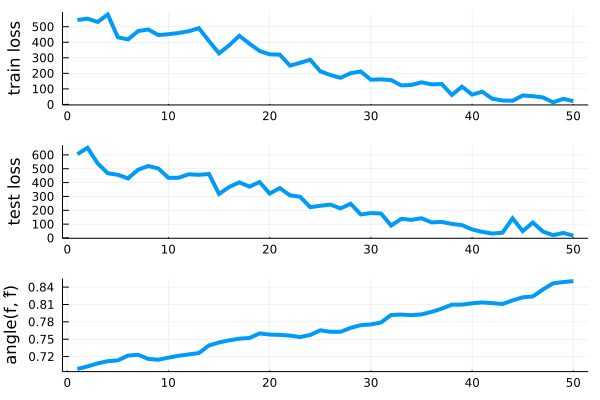

In [117]:
theme(:default, lw=4, label=nothing)

plot(
    plot(train_loss_hist, ylabel="train loss"),
    plot(test_loss_hist, ylabel="test loss"),
    plot(acc_hist, ylabel="angle(f, f̂)"),
    layout=(3, 1)
)

norm(f̂) = 226.1294427250487
norm(f) = 49.8894541160346


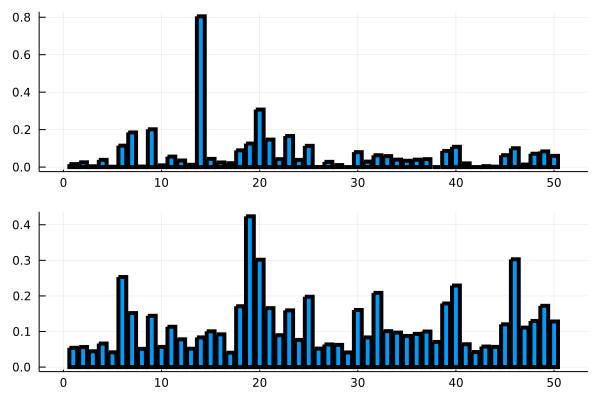

In [106]:
@show norm(f̂)
@show norm(f)
plot(bar(f̂ / norm(f̂)), bar(f/norm(f)), layout=(2, 1))

In [115]:
merit_order = sortperm(f)
est_merit_order = sortperm(f̂)

50-element Vector{Int64}:
 29
 38
 42
 26
  5
 44
  8
  3
 43
 10
 28
 13
 47
  ⋮
 18
 46
 40
 25
  6
 19
 21
 23
  7
  9
 20
 14